In [3]:
!pip install gdown

Defaulting to user installation because normal site-packages is not writeable
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [7]:
# @title Download MoNuSeg Training Data and Convert Masks
import gdown
import os
from PIL import Image
import numpy as np
import xml.etree.ElementTree as ET
from skimage.draw import polygon

def parse_xml_to_mask(xml_path, image_size):

  width, height = image_size
  mask = np.zeros((height, width), dtype=np.uint8)

  tree = ET.parse(xml_path)
  root = tree.getroot()

  for region in root.findall('.//Region'):
    for vertices in region.findall('.//Vertices'):
      row_cords = []
      col_cords = []
      for vertex in vertices.findall('.//Vertex'):
        x = float(vertex.get('X'))
        y = float(vertex.get('Y'))

        row_cords.append(y)
        col_cords.append(x)

      rr, cc = polygon(row_cords, col_cords, (height, width))
      mask[rr, cc] = 1

  return mask

if not os.path.exists('MoNuSeg'):
  # -c to skip if already downloaded. MoNuSeg is hosted on google drive
  gdown.download(id = "1ZgqFJomqQGNnsx7w7QBzQQMVA16lbVCA", output = "MoNuSeg.zip")
  !unzip MoNuSeg.zip -d MoNuSeg
  !rm MoNuSeg.zip

  os.mkdir('MoNuSeg/MoNuSeg 2018 Training Data/Proccessed Annotations')
  os.mkdir('MoNuSeg/MoNuSeg 2018 Training Data/Proccessed Images')

  # Convert masks to 1,000 by 1,000 px pngs
  for file in os.listdir('MoNuSeg/MoNuSeg 2018 Training Data/Annotations'):
    if file.endswith('.xml'):
      xml_path = os.path.join('MoNuSeg/MoNuSeg 2018 Training Data/Annotations', file)
      mask = parse_xml_to_mask(xml_path, (1000, 1000))
      mask = Image.fromarray(mask)
      mask.save(os.path.join('MoNuSeg/MoNuSeg 2018 Training Data/Proccessed Annotations', file[:-4] + '.png'))
  # Convert compressed tiff to png for faster loading
  for file in os.listdir('MoNuSeg/MoNuSeg 2018 Training Data/Tissue Images'):
    if file.endswith('.tif'):
      img_path = os.path.join('MoNuSeg/MoNuSeg 2018 Training Data/Tissue Images', file)
      img = Image.open(img_path)
      img.save(os.path.join('MoNuSeg/MoNuSeg 2018 Training Data/Proccessed Images', file[:-4] + '.png'))

else:
  print("MoNuSeg Training Data already downloaded")

Downloading...
From (original): https://drive.google.com/uc?id=1ZgqFJomqQGNnsx7w7QBzQQMVA16lbVCA
From (redirected): https://drive.google.com/uc?id=1ZgqFJomqQGNnsx7w7QBzQQMVA16lbVCA&confirm=t&uuid=6fc20927-ba08-4028-b69b-56409fa1c973
To: /home/chl177/private/ECE285-Final-Project/MoNuSeg.zip
100%|██████████| 126M/126M [00:03<00:00, 40.8MB/s] 


Archive:  MoNuSeg.zip
   creating: MoNuSeg/MoNuSeg 2018 Training Data/
  inflating: MoNuSeg/MoNuSeg 2018 Training Data/.DS_Store  
   creating: MoNuSeg/__MACOSX/
   creating: MoNuSeg/__MACOSX/MoNuSeg 2018 Training Data/
  inflating: MoNuSeg/__MACOSX/MoNuSeg 2018 Training Data/._.DS_Store  
   creating: MoNuSeg/MoNuSeg 2018 Training Data/Annotations/
  inflating: MoNuSeg/MoNuSeg 2018 Training Data/Annotations/TCGA-38-6178-01Z-00-DX1.xml  
   creating: MoNuSeg/__MACOSX/MoNuSeg 2018 Training Data/Annotations/
  inflating: MoNuSeg/__MACOSX/MoNuSeg 2018 Training Data/Annotations/._TCGA-38-6178-01Z-00-DX1.xml  
  inflating: MoNuSeg/MoNuSeg 2018 Training Data/Annotations/TCGA-HE-7129-01Z-00-DX1.xml  
  inflating: MoNuSeg/__MACOSX/MoNuSeg 2018 Training Data/Annotations/._TCGA-HE-7129-01Z-00-DX1.xml  
  inflating: MoNuSeg/MoNuSeg 2018 Training Data/Annotations/TCGA-A7-A13E-01Z-00-DX1.xml  
  inflating: MoNuSeg/__MACOSX/MoNuSeg 2018 Training Data/Annotations/._TCGA-A7-A13E-01Z-00-DX1.xml  
  inf

In [8]:
# @title MoNuSeg Data Set
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import v2


class MoNuSegDataset(Dataset):
  def __init__(self, root_dir, transform = None):
    """
    Args:
        root_dir (string): Directory with all the images and masks.
        transform (callable, optional): Optional transform to be applied
            on a sample. Default is random 256x256 crop.
    """
    self.root_dir = root_dir
    self.image_dir = os.path.join(root_dir, 'Proccessed Images')
    self.mask_dir = os.path.join(root_dir, 'Proccessed Annotations')

    if transform is None:
      transform = v2.Compose([v2.ToImage(), v2.RandomCrop((256,256))])

    self.transform = transform

    # Sort to ensure images and masks match
    self.images = sorted(os.listdir(self.image_dir))
    self.masks = sorted(os.listdir(self.mask_dir))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img = Image.open(os.path.join(self.image_dir, self.images[idx]))
    mask = Image.open(os.path.join(self.mask_dir, self.masks[idx]))

    img, mask = self.transform(img, mask)

    return {"image": img, "mask": mask}

In [9]:
# @title Create Dataloader
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

dataset = MoNuSegDataset('MoNuSeg/MoNuSeg 2018 Training Data')

# Pin memory to speed up loading to GPU. Increase # workers
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)

Number of train samples: 37


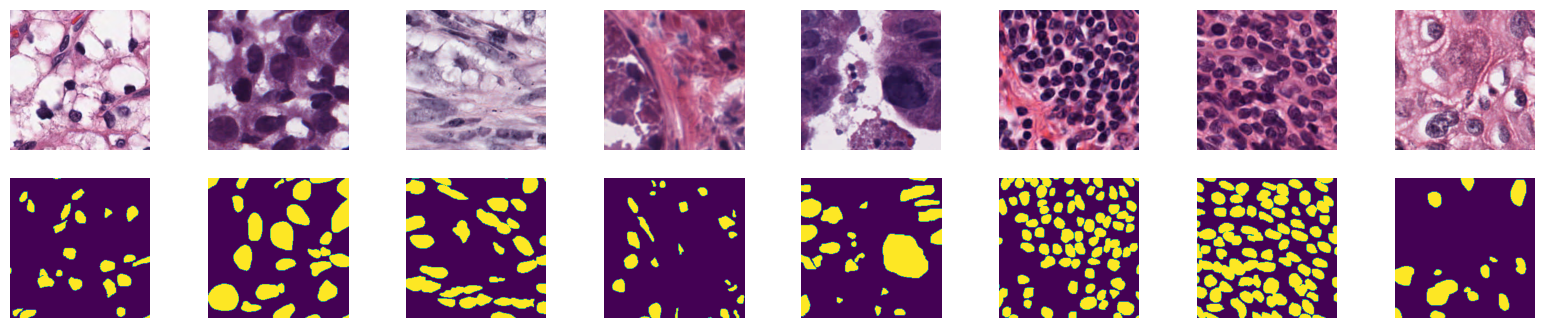

In [10]:
# @title Visualize Batch

images = next(iter(dataloader))

print(f"Number of train samples: {len(dataset)}")

fig, axes = plt.subplots(2, 8, figsize=(20, 4))
for i in range(8):
  axes[0,i].imshow(images["image"][i].permute(1, 2, 0))
  axes[0,i].axis('off')
  axes[1,i].imshow(images["mask"][i].permute(1, 2, 0))
  axes[1,i].axis('off')

plt.show()

In [11]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda
